# Week8 Country Data Cluster

## 1.Introduction


In Week 6's lecture, I learned how to classify labeled data using supervised learning algorithms. At that time, I wondered how to classify unlabeled data using ML techniques. This week's introduction to unsupervised clustering models has provided an direction.

The lecture primarily focused on `clustering` problems involving image data and numerical data. Given my preference for analyzing numerical data, I selected a dataset containing multiple features from different countries as the subject of my project. Another reason for choosing this dataset is because it has a smaller data size, in this case, my device might be sufficient to support clustering tasks using some complex models.

Additionally, the dimensionality reduction and visualization techniques introduced in the lecture will be applied and further explored in this project.

The project is structured into three main components: `data preprocessing and analysis`, `clustering model training`, and `visualization and interpretation of clustering results`.

In [3]:
import random, os, sys, shutil
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# !pip install yellowbrick

## 2. Data Preprocess And Analysis


In [5]:
df = pd.read_csv(r'../Datasets\Country-data.csv')

In [6]:
df.shape

(167, 10)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


* This dataset does not contain any missing values. 

* It includes 9 features that describe various aspects of different countries, spanning multiple dimensions such as economy and health.

* The features are `numerical`, consisting of both `integer` and `float` data types. Therefore, methods like `.describe()` and `.hist()` were applied to examine the statistical values and distribution of these features.

In [8]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
child_mort,167.0,38.27,40.33,2.60,8.25,19.30,62.10,208.00
exports,167.0,41.11,27.41,0.11,23.80,35.00,51.35,200.00
health,167.0,6.82,2.75,1.81,4.92,6.32,8.60,17.90
imports,167.0,46.89,24.21,0.07,30.20,43.30,58.75,174.00
income,167.0,17144.69,19278.07,609.00,3355.00,9960.00,22800.00,125000.00
inflation,167.0,7.78,10.57,-4.21,1.81,5.39,10.75,104.00
life_expec,167.0,70.56,8.89,32.10,65.30,73.10,76.80,82.80
total_fer,167.0,2.95,1.51,1.15,1.80,2.41,3.88,7.49
gdpp,167.0,12964.16,18328.70,231.00,1330.00,4660.00,14050.00,105000.00


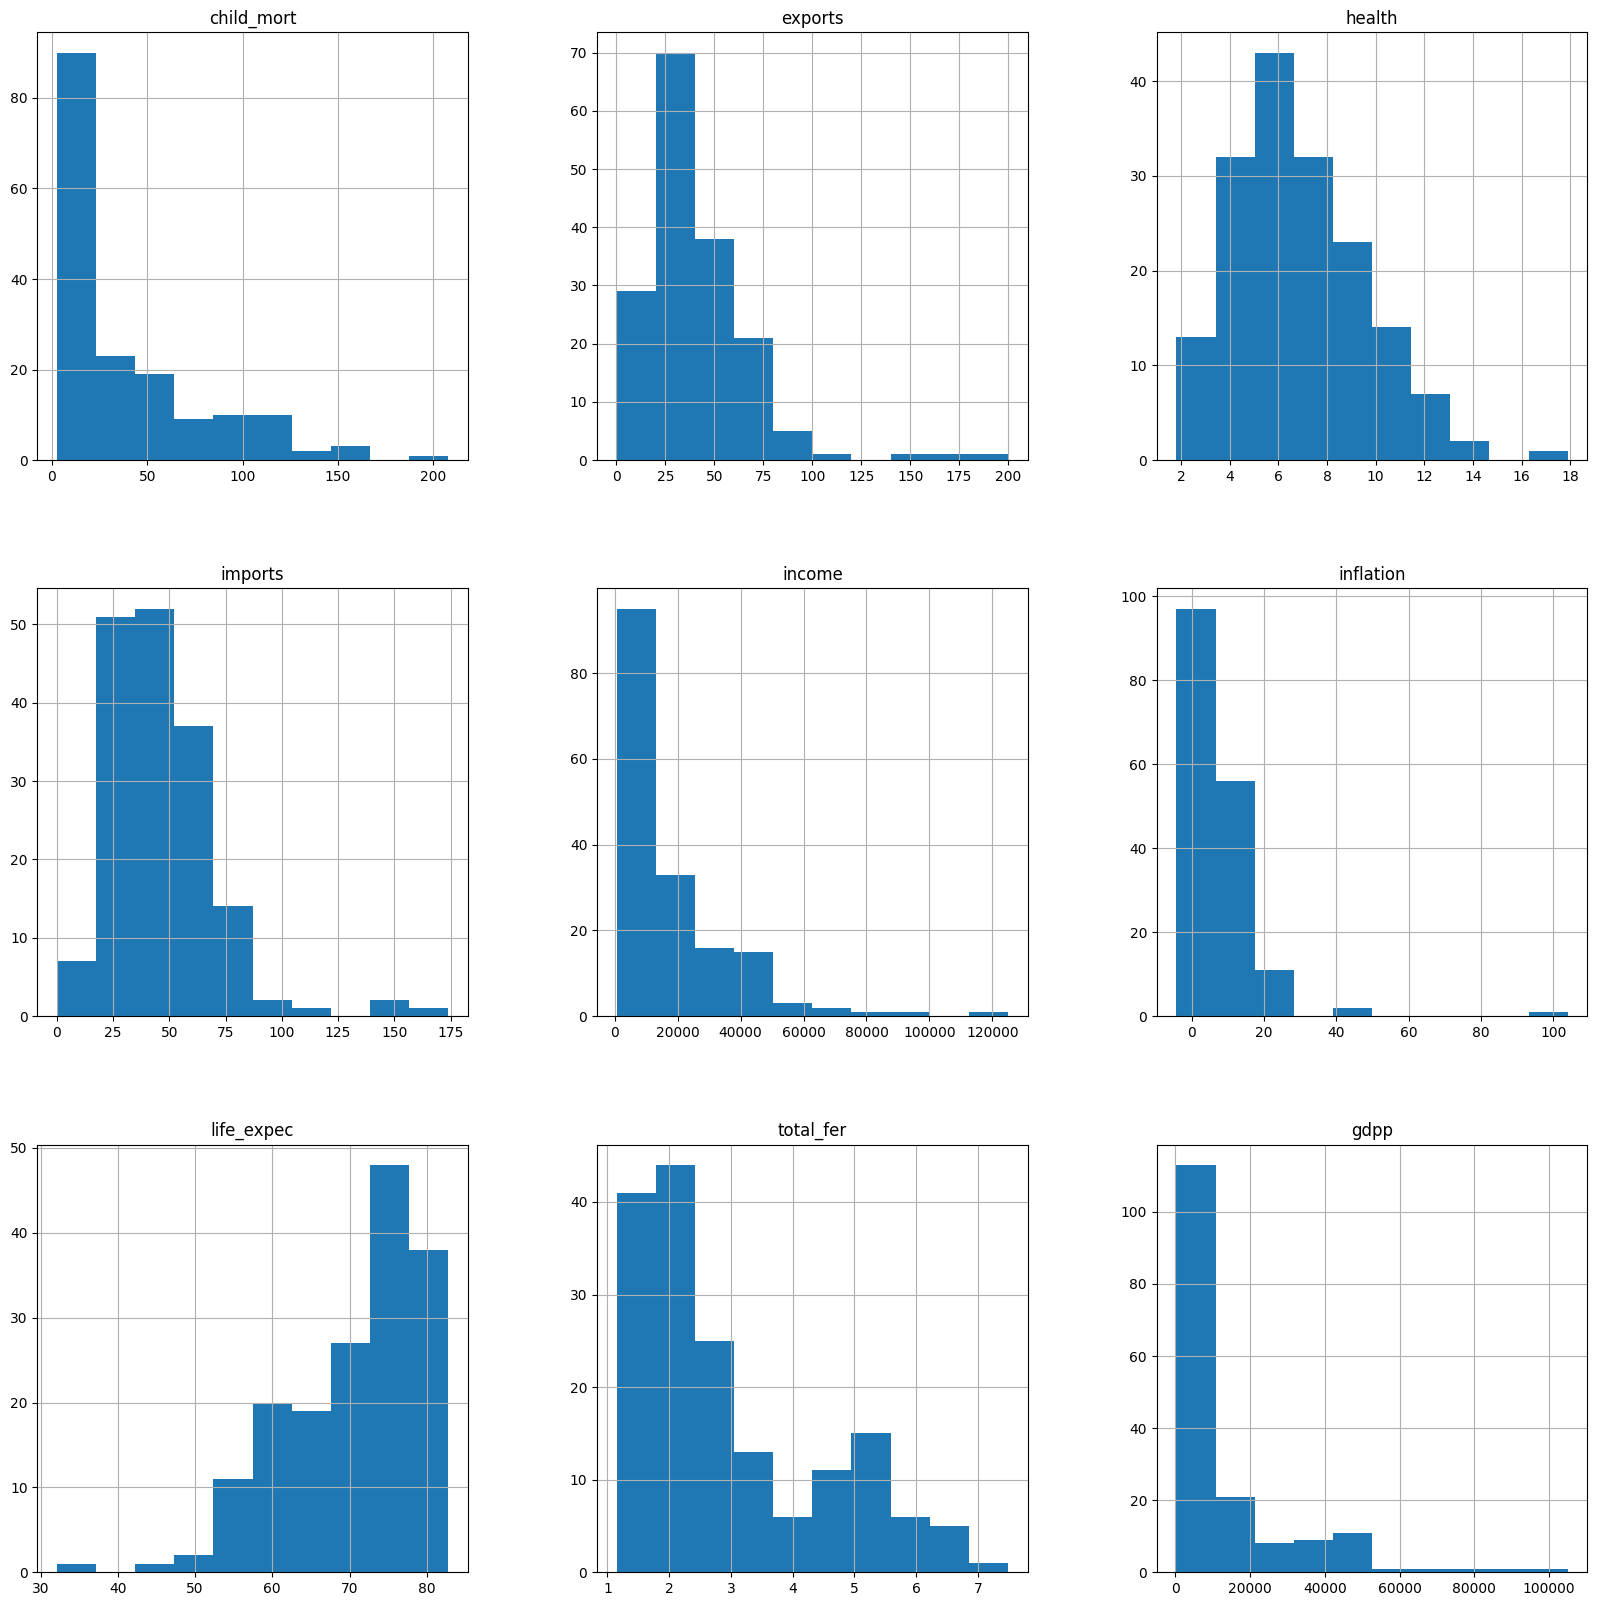

In [9]:
p = df.hist(figsize = (20,20))

Combining the visualizations and statistical values, I observed the following:

* GDPP and Child Mortality have a higher mean than the 50th percentile, indicating a heavily right-skewed distribution.

* Most of the feature values exhibit right-skewed distributions, while Life Expectancy shows a left-skewed distribution.

* Only Health has a distribution that is closer to normal.

* Nearly all features contain some outliers.

Additionally, I noticed that some features exhibit a certain degree of correlation, such as Income and GDPP or Child Mortality and Health. Further analyzing the relationships between these features seems to be a reasonable direction.

The `.pairplot()` function is well-suited for this purpose. It visualizes the pairwise relationships between all `numerical variables` while displaying the univariate distribution of each variable along the diagonal.

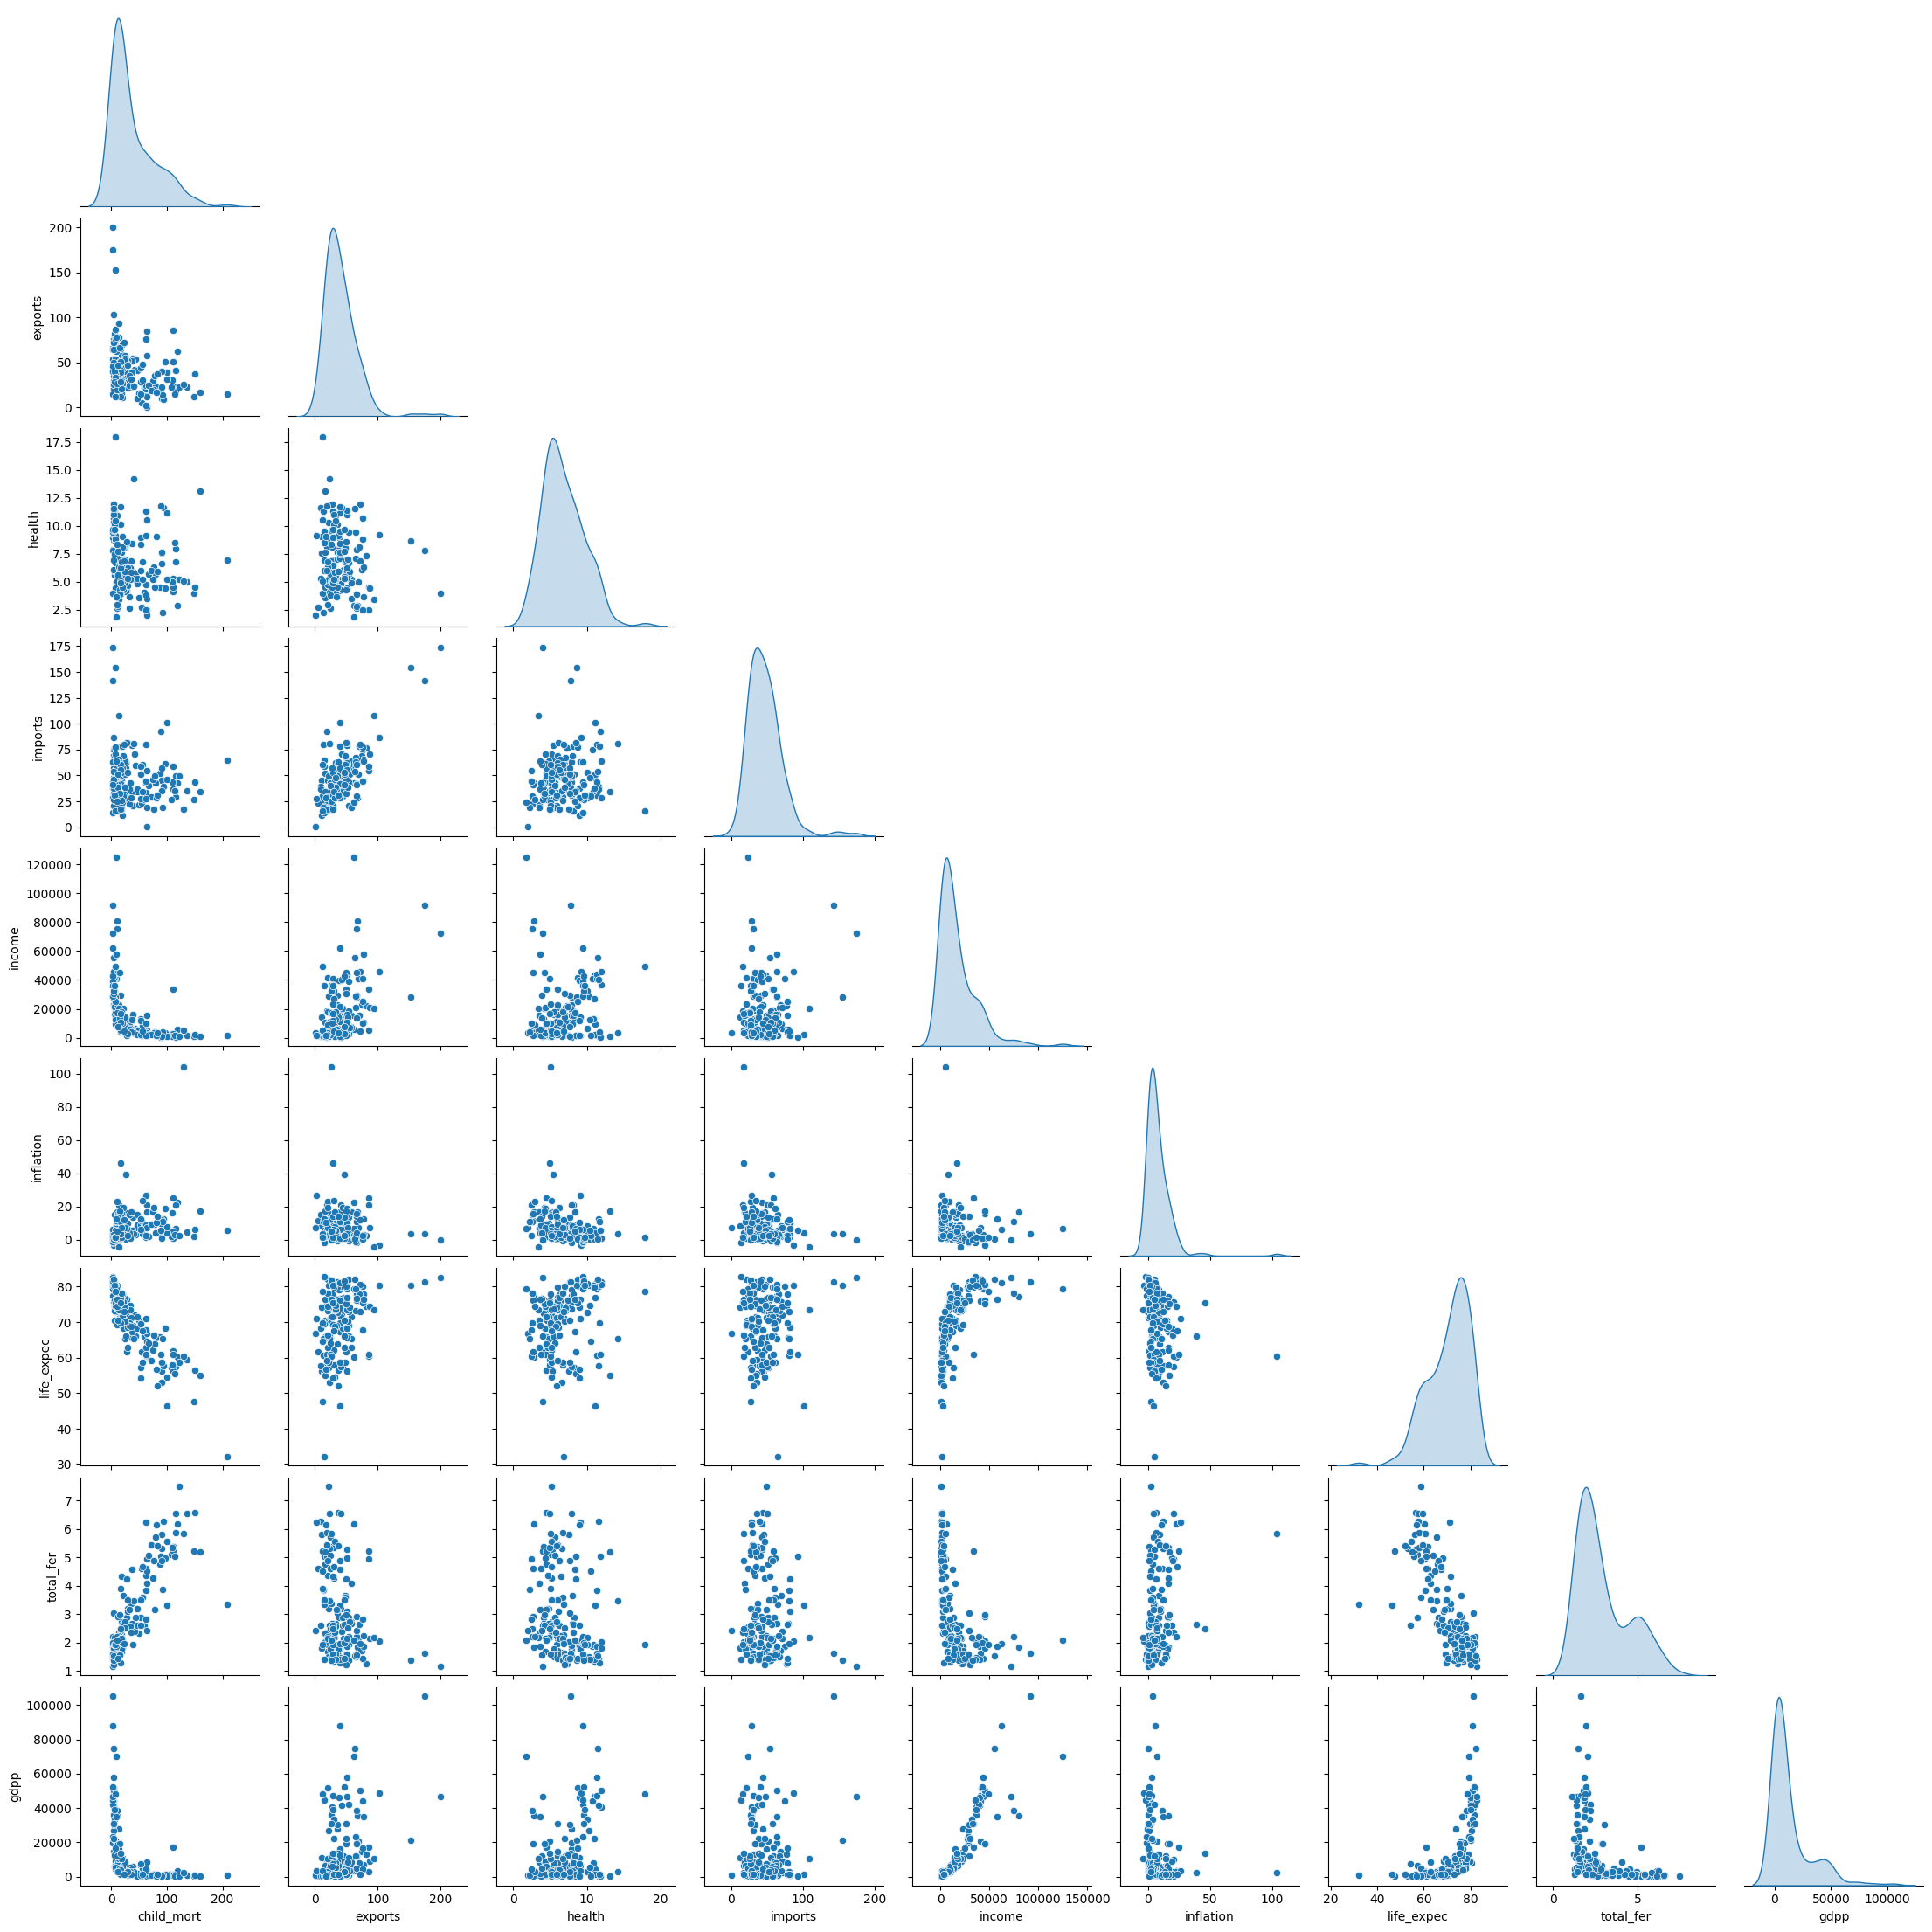

In [10]:
sns.pairplot(df,diag_kind = 'kde', corner = True)

Among the economic features:

* `Income` and `GDPP` appear to have a strong correlation.

* Life expectancy (life_expec) and child mortality (child_mort) appear to have a strong negative correlation.

* Additionally, the higher the `income` or `GDPP`, the lower the `child mortality` tends to be.


Next, I used a `heatmap` to further examine the exact correlation values between different features.

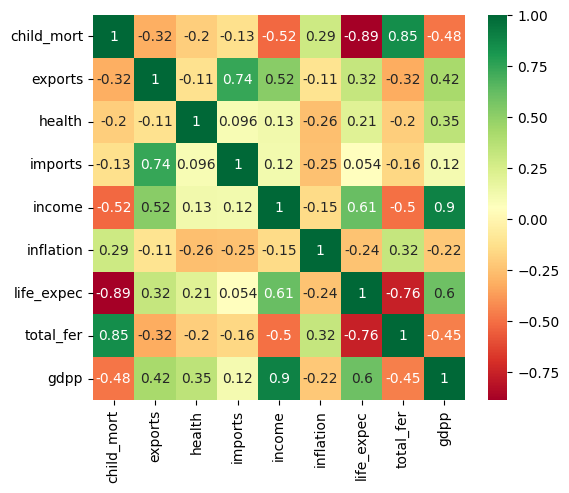

In [11]:
plt.figure(figsize=(6,5))  # on this line I just set the size of figure to 12 by 10.
p=sns.heatmap(df.drop('country',axis=1).corr(), annot=True,cmap ='RdYlGn')

Overall, most features exhibit a certain degree of correlation with each other. Some feature pairs, however, show particularly strong correlations. For example:

* imports and Exports have very high positive correlation. (+0.74)

* Life Expectancy and Child mortality has very high negative correlation. (-0.89)

* Total Fertility and child mortality has a high correlation. (+0.85)

* GDPP and Income has the heigest positive correlation. (+0.9)

This may negatively impact the subsequent clustering model training for that Highly correlated features tend to provide similar information.

Therefore, dimensionality reduction techniques, such as `PCA`, may need to be applied.

## 3. Cluster Model Train

First, I removed the `country` column from the original dataset, keeping only the remaining features, and then `standardized` the data.

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x = df.drop('country',axis=1)
sc_x = scaler.fit_transform(x)

In my previous project, I manually adjusted the `n_components` parameter for several times to determine the optimal value for `PCA`, which proved to be a relatively inefficient approach.

Through further exploration, I learned that the `explained_variance_ratio_` can be used to determine the most suitable Eigenvalue needed to retain sufficient information.

Similar to the Elbow Plot, I need to identify the inflection point in this plot to determine the optimal number of components (n_components).

In [13]:
from sklearn.decomposition import PCA
pca = PCA()
x_pca = pca.fit_transform(sc_x)
pca.explained_variance_

array([4.16057017, 1.55566165, 1.1774338 , 1.00077724, 0.66459866,
       0.224928  , 0.1141221 , 0.08884738, 0.06727787])

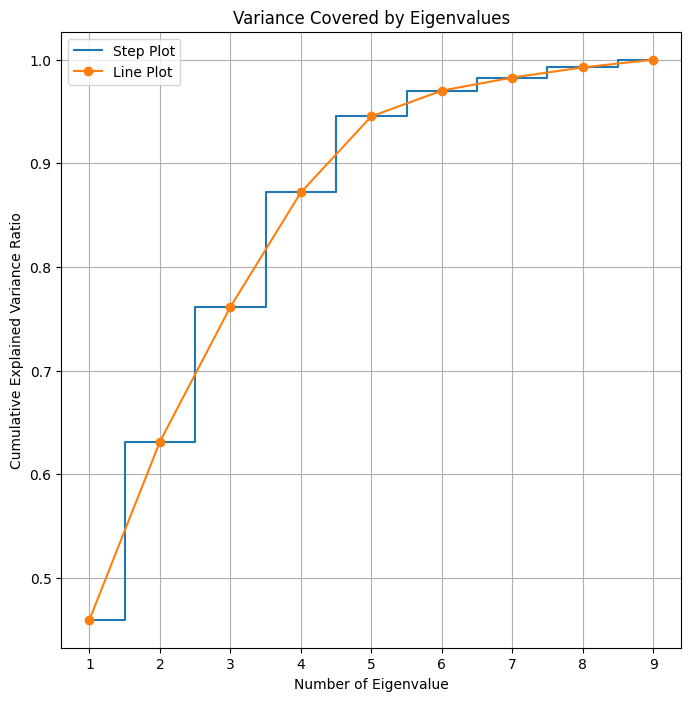

In [14]:
plt.figure(figsize=(8, 8))


explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

plt.step(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, where='mid', label="Step Plot")
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-', label="Line Plot")

plt.xlabel('Number of Eigenvalue')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Variance Covered by Eigenvalues')
plt.legend()
plt.grid()

plt.show()

When the Eigenvalue reaches 5, it appears to be the inflection point in the plot and can explain approximately 95% of the variance in the data. 

Therefore, I determined that the optimal value for n_components in PCA is 5.

In [15]:
num_dimensions = 5
pca = PCA(n_components = num_dimensions)
x_pca = pca.fit_transform(sc_x)

After reducing the dimensionality of the features, I need to determine the optimal number of clusters (K) for the K-Means model.

The lecture introduced the `Elbow Plot` method, which helps identify the optimal K by locating the inflection point in the curve.

However, in some cases, the curve may be smooth, making it difficult to pinpoint the exact elbow. To avoid misjudgment, I learned a new algorithm that can automatically detect the elbow point and mark it directly on the plot.

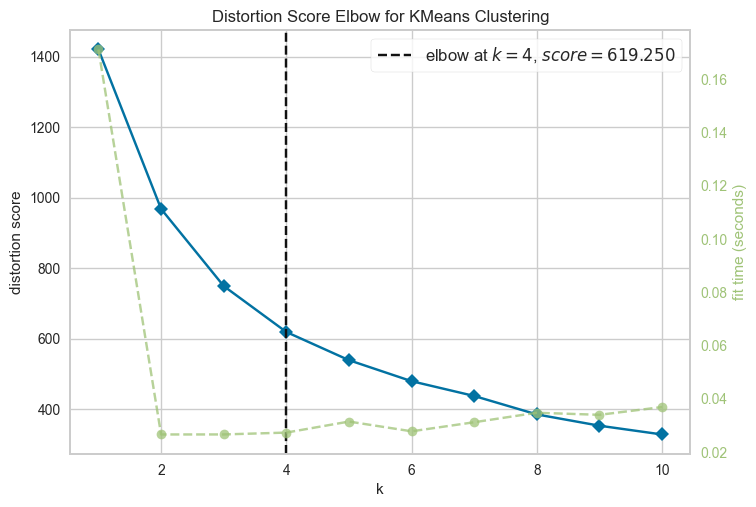

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [16]:
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(KMeans(n_init=10, random_state = 42), k=(1, 11))
visualizer.fit(x_pca)
visualizer.poof()

At the same time, I also attempted to using the features without dimensionality reduction to find K value. 

The results showed that the optimal K value remained the same as in the case with dimensionality reduction.

In [17]:
# visualizer = KElbowVisualizer(KMeans(), random_state = 42, k = (1, 11))
# visualizer.fit(sc_x)
# visualizer.poof()

After determining the optimal K value, I retrained the KMeans model and performed the following operations on the obtained `cluster labels`:

* Added a new column, `KM_cluster`, to the original dataset to store the corresponding cluster labels for each country.

* Calculated the `count` and `percentage` of each cluster and saved them into a new DataFrame for an overview.

In [18]:
k = 4
kmeans = KMeans(n_clusters=k, random_state = 42)
kmeans.fit(x_pca)
KM_pred = pd.Series(kmeans.labels_, name="Cluster")
x["KM_cluster"] = kmeans.labels_


KMcluster_stats = pd.DataFrame({
    "Count": KM_pred.value_counts(),
    "Percent": round(KM_pred.value_counts(normalize=True) * 100, 2)
})

print(KMcluster_stats.sort_index()) 

         Count  Percent
Cluster                
0           89    53.29
1           30    17.96
2           45    26.95
3            3     1.80


It can be observed that the countries are divided into four clusters, with the `Cluster 3` containing only 3 countries, which caught my attention.

This raises the question of whether the KMeans clustering results are inaccurate or if this cluster possesses unique characteristics.

After consideration, I decided to experiment with other clustering models and compare the results to make a more informed judgment.

After studying different methods, I decided to use `Agglomerative Clustering`.

Agglomerative Clustering is a distance-based algorithm used for unsupervised learning problems.

It constructs a hierarchy of clusters in the form of a tree, known as a `dendrogram`.

First, I plotted the dendrogram to determine the optimal number of clusters.

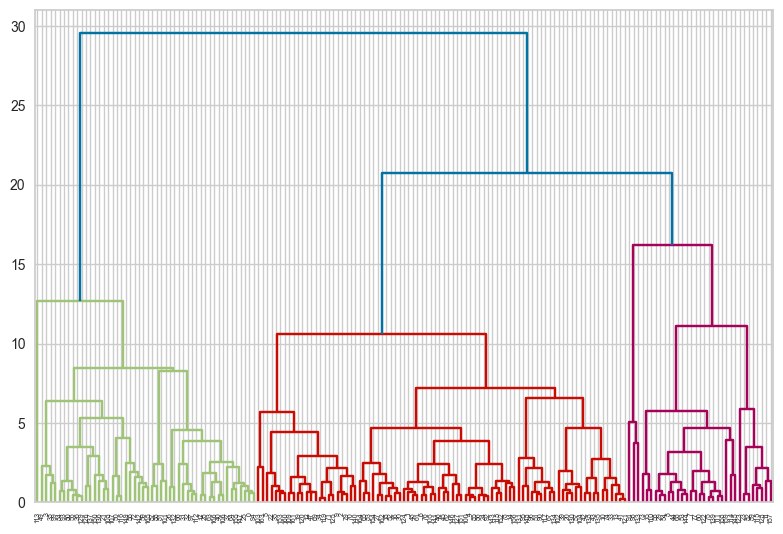

In [19]:
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_data = linkage(x_pca, method = 'ward', metric = 'euclidean')
dendrogram(linkage_data)
plt.tight_layout()
plt.show()

The diagram suggests that setting `n_clusters = 3` is a reasonable choice.

In [20]:
from sklearn.cluster import AgglomerativeClustering 

Agg_cluster = AgglomerativeClustering(n_clusters = 3, metric = 'euclidean', linkage = 'ward')
Agg_cluster.fit(x_pca)

AgglomerativeClustering(n_clusters=3)

In [21]:
Agg_pred = pd.Series(Agg_cluster.labels_, name="Cluster")

x["Agglomerative_cluster"] = Agg_pred

Aggcluster_stats = pd.DataFrame({
    "Count": Agg_pred.value_counts(),
    "Percent": round(Agg_pred.value_counts(normalize=True) * 100, 2)
})

print(Aggcluster_stats.sort_index()) 

         Count  Percent
Cluster                
0           33    19.76
1           50    29.94
2           84    50.30


In [22]:
x.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,KM_cluster,Agglomerative_cluster
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,2,1
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,0,2
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,0,2
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,2,1
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,0,2


After training both clustering models, I need to compare their performance. 

Since clustering is an unsupervised learning task, I cannot evaluate model accuracy using metrics like `test_scores`.

However, there are alternative methods to quantify the effectiveness of the models.

Here, I chose `silhouette score` and `davies bouldin score` as evaluation criteria.

In [23]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

sil_score = silhouette_score(x_pca,KM_pred)
print(f"Silhouette Score: {sil_score:.2f}")

db_score = davies_bouldin_score(x_pca,KM_pred)
print(f"Davies Bouldin Score: {db_score:.2f}")


Silhouette Score: 0.33
Davies Bouldin Score: 0.97


In [24]:
sil_score = silhouette_score(x_pca,Agg_pred)
print(f"Silhouette Score: {sil_score:.2f}")

db_score = davies_bouldin_score(x_pca,Agg_pred)
print(f"Davies Bouldin Score: {db_score:.2f}")

Silhouette Score: 0.30
Davies Bouldin Score: 1.25


KMeans vs. Agglomerative Clustering

* Silhouette Score: The closer to 1, the better the clustering performance, indicating higher intra-cluster density.

* Davies-Bouldin Score: The lower, the better, indicating better separation between clusters.

After comparison, KMeans outperforms Agglomerative Clustering in terms of clustering effectiveness.

## 4. Cluster Visualization and Analysis

While training the model, I have already created a corresponding column in the original dataset to store the predicted cluster labels.

To understand the differences between clusters, I believe analyzing features of clusters is necessary.

At this stage, boxplots are a good choice. They allow me to quickly observe key statistical properties, including median, quartiles, and outliers.

Thus, I applied boxplots to each feature, except for the cluster label column.

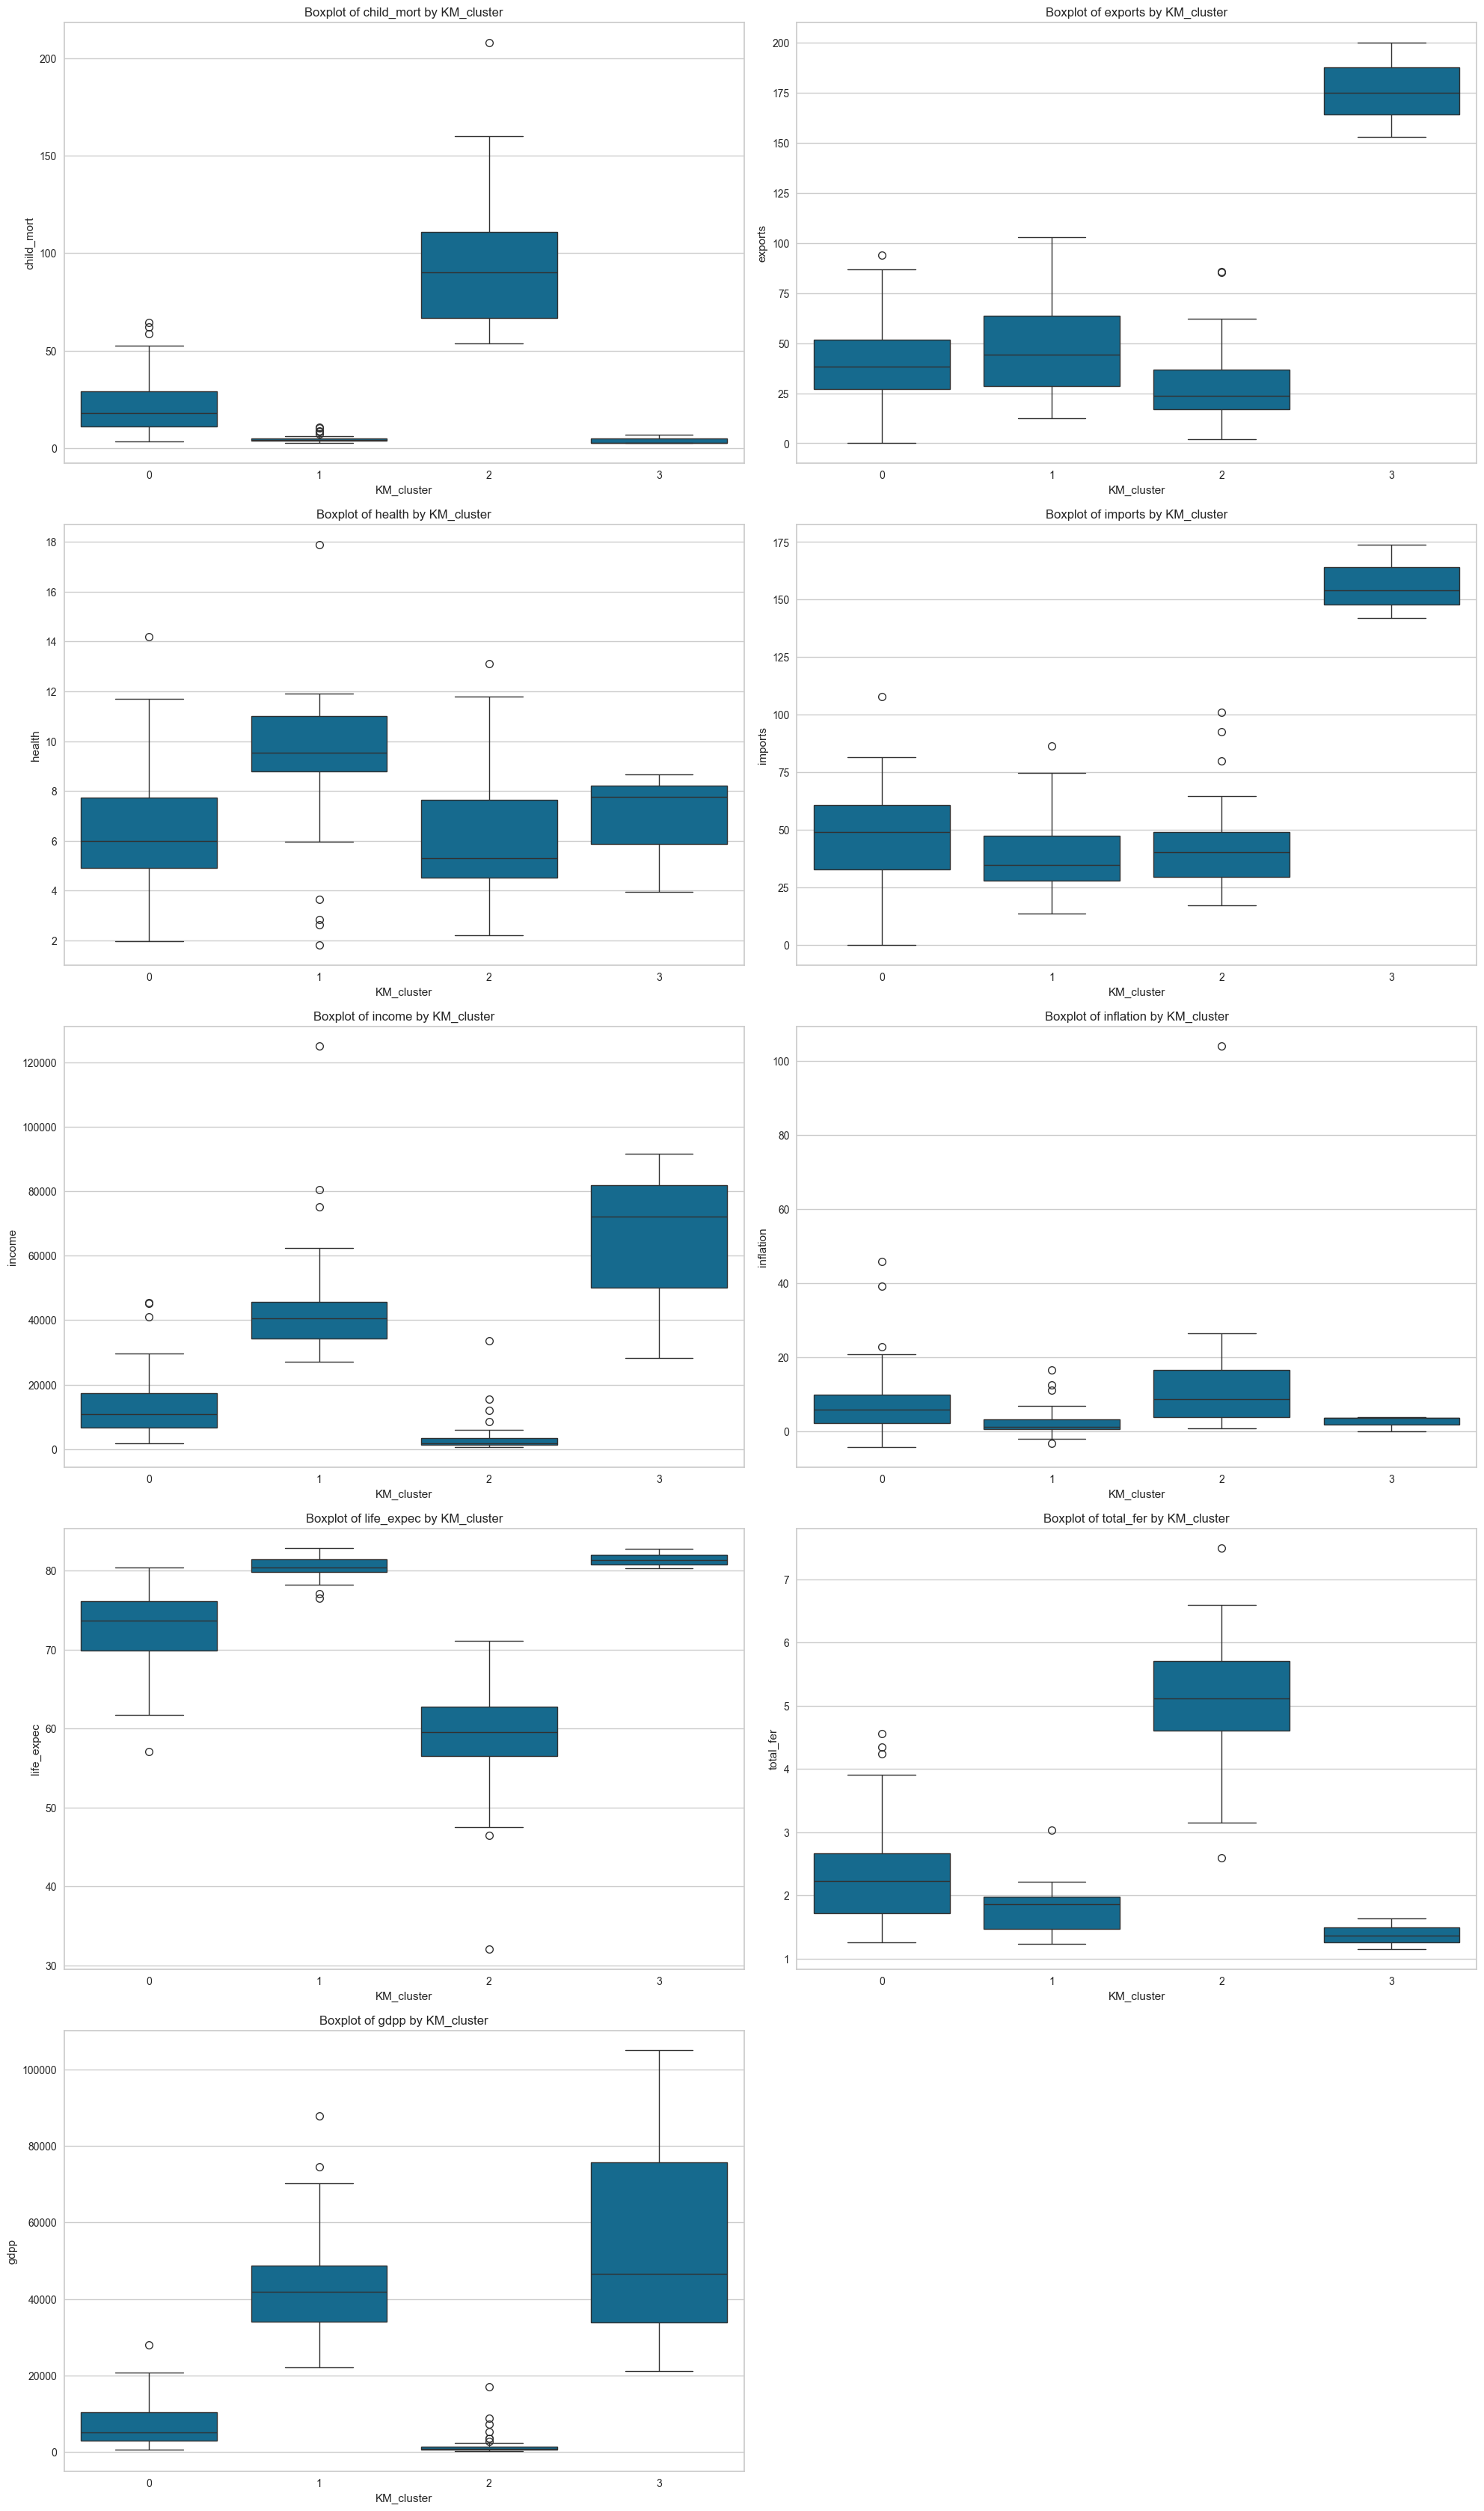

In [25]:
num_features = x.select_dtypes(include=["number"]).columns[:-2].tolist()

plt.figure(figsize=(20, 40))

for i, feature in enumerate(num_features, 1):
    plt.subplot(6,2,i)
    sns.boxplot(x=x["KM_cluster"], y=x[feature])
    plt.title(f"Boxplot of {feature} by KM_cluster")

plt.tight_layout()  
plt.show()

Findings:

    Cluster 0:

        * Countries in this group have relatively low GDP and moderate income levels.

        * Their economic structure relies more on imports.

        * Other aspects, such as health expenditures, are middle-range among all clusters.

        * These characteristics align well with developing countries.

    Cluster 1:

        * This cluster includes countries with high GDP and income levels.

        * life_expec is relatively higher.
        
        * A key distinguishing feature is that healthcare expenditures are the highest, and inflation is the lowest.

        * These factors suggest that this cluster represents developed countries.
    
    Cluster 2:

        * This cluster likely represents less developed countries.

        * GDP and income levels are the lowest, while child mortality and inflation rates are the highest.

        * Health expenditures are also the lowest, indicating potential challenges in healthcare accessibility.

        * Birth rates (total_fer) are the highest in this group.
    
    Cluster 3:

        * This cluster consists of only three countries.

        * They exhibit the highest GDP and income levels, but also the lowest birth rates(total_fer).
        
        * Trade volume (both imports and exports) is the highest.
        
        * Contrary to my initial assumption, healthcare spending is not the highest, possibly due to strong 
        welfare policies.
        
        * These countries may represent the most advanced economies among developed nations.

In [26]:
pd.DataFrame(x[x['KM_cluster'] == 3])

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,KM_cluster,Agglomerative_cluster
91,2.8,175.0,7.77,142.0,91700,3.620,81.3,1.63,105000,3,0
98,6.8,153.0,8.65,154.0,28300,3.830,80.3,1.36,21100,3,0
133,2.8,200.0,3.96,174.0,72100,-0.046,82.7,1.15,46600,3,0


In [27]:
row_1 = df.iloc[91]["country"] 
row_2 = df.iloc[98]["country"] 
row_3 =  df.iloc[133]["country"] 
print(row_1)
print(row_2)
print(row_3)


Luxembourg
Malta
Singapore


This is the boxplot visualization for `Agglomerative Clustering`, which clearly illustrates how the three clusters correspond to different types of countries (Developed Countries, Developing Countries, Less Developed Countries ).

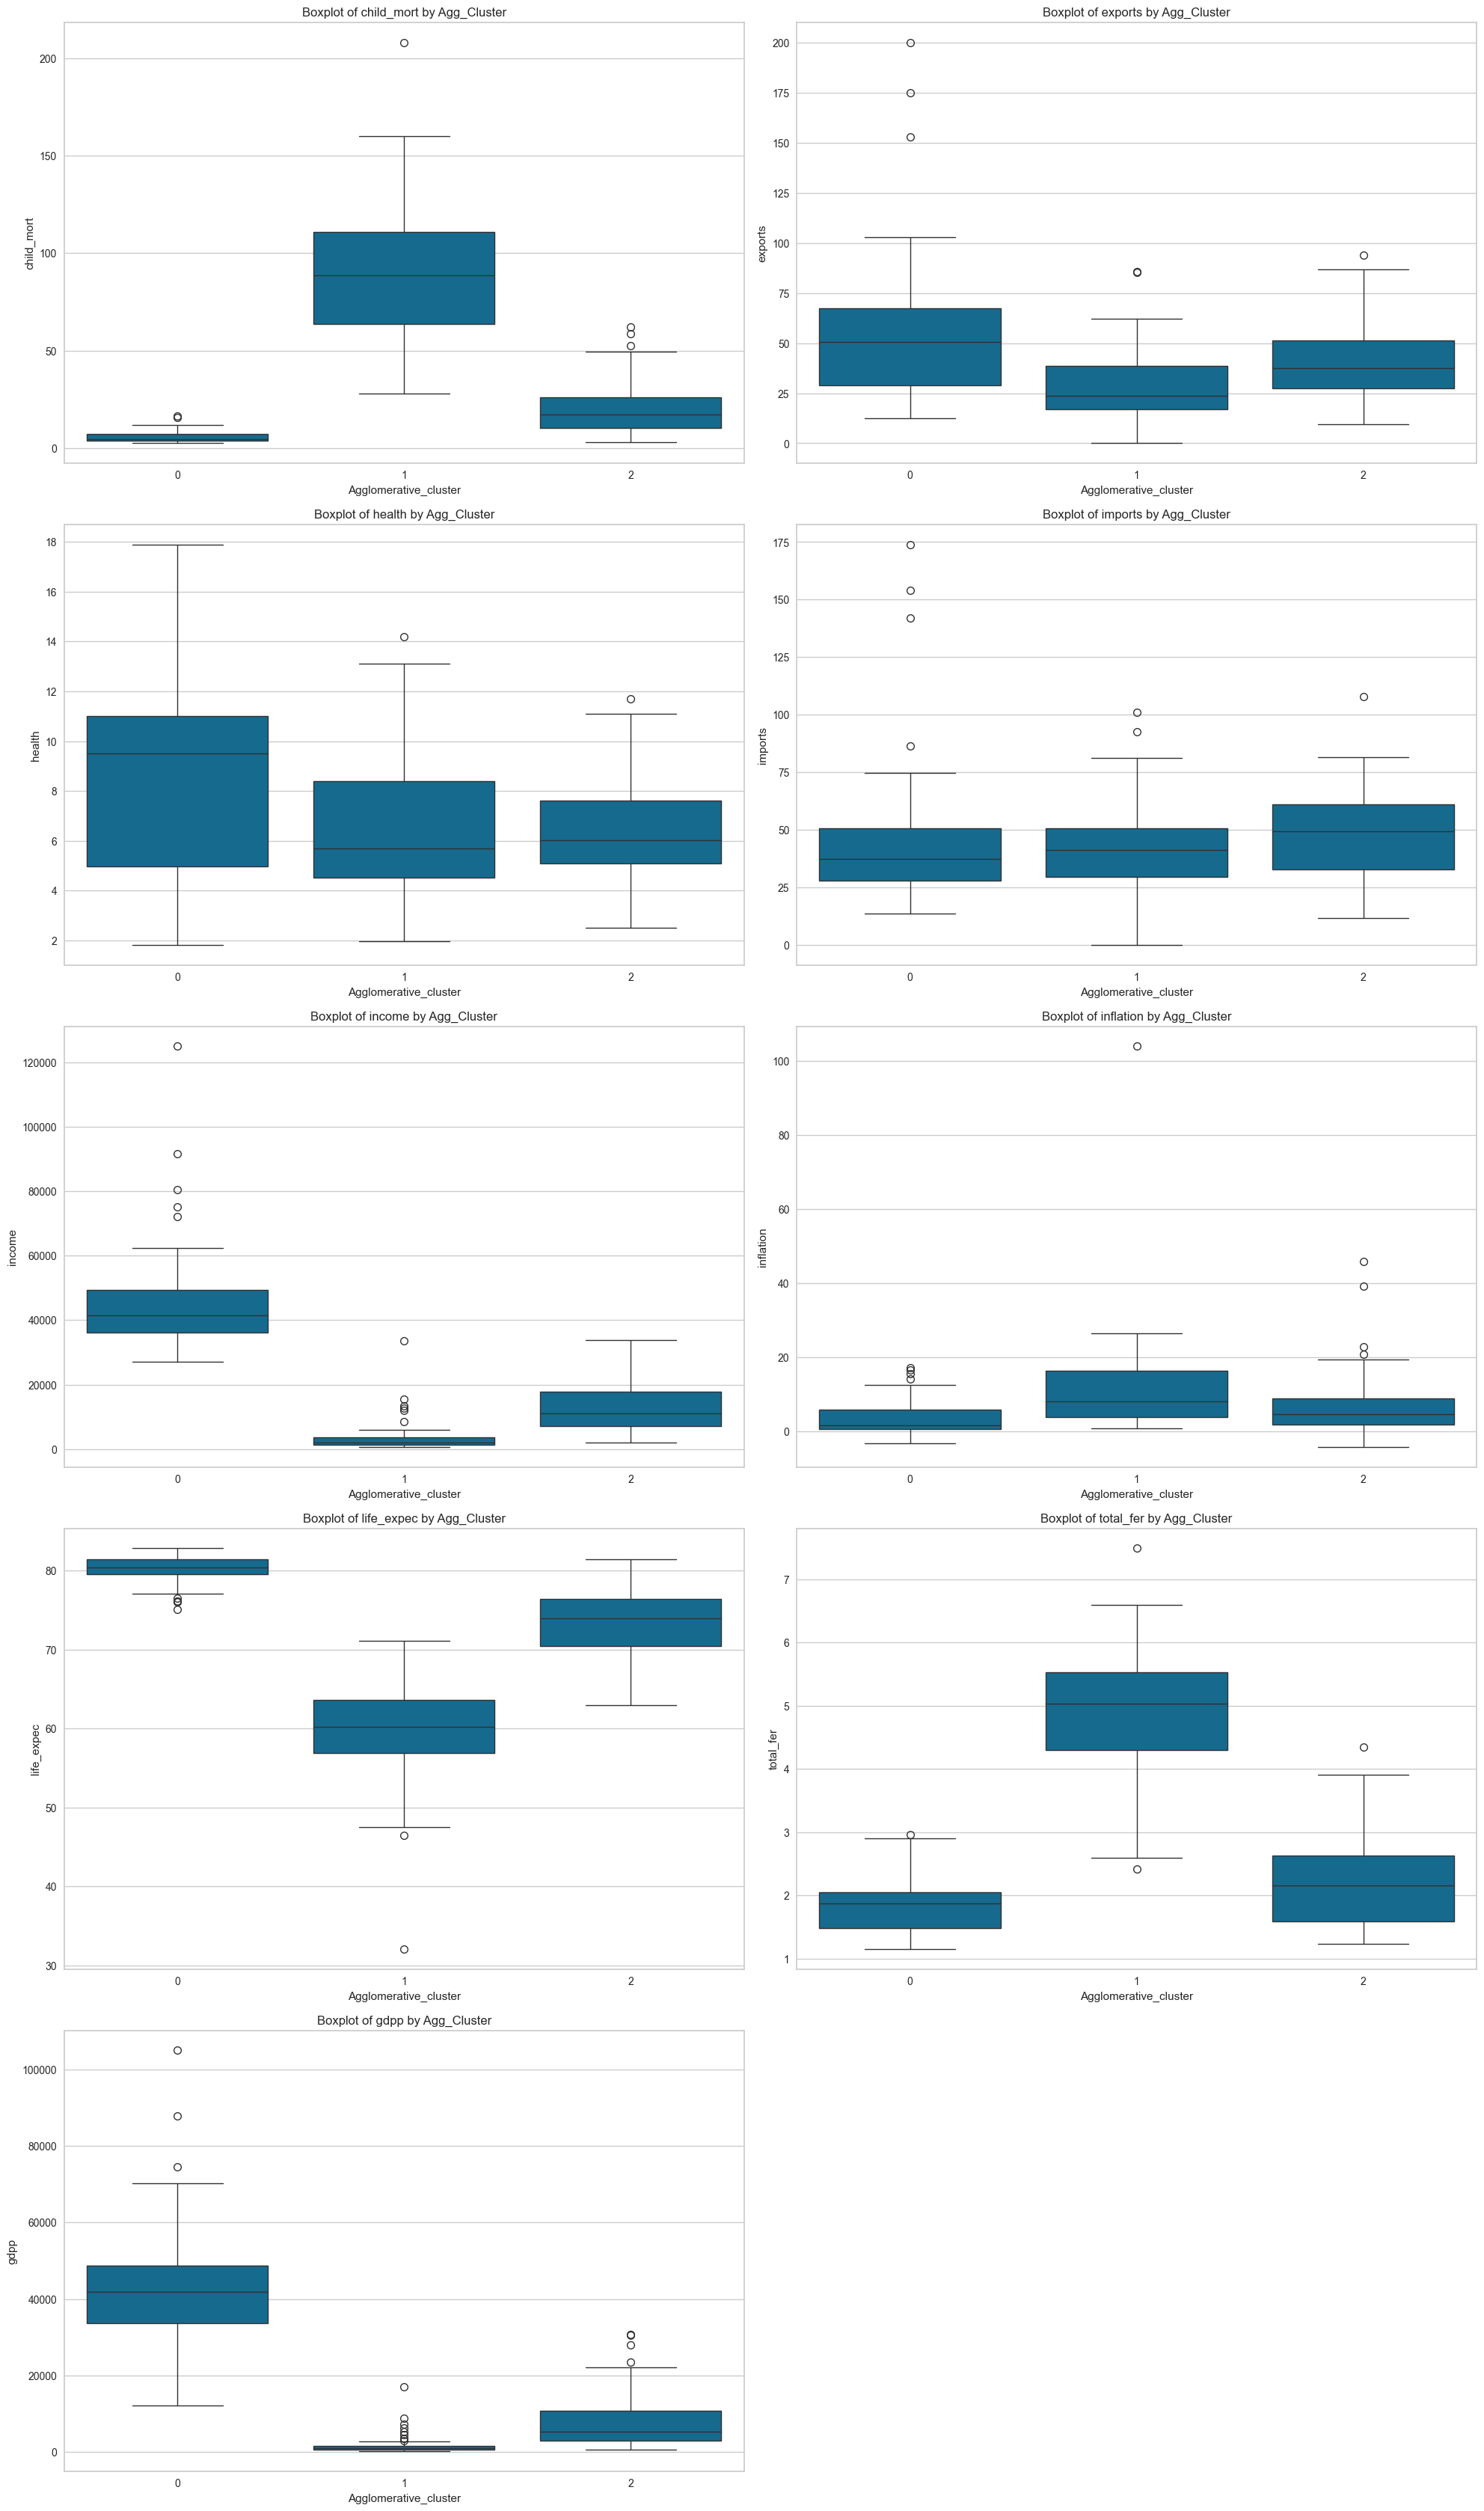

In [28]:
plt.figure(figsize=(20, 40))


for i, feature in enumerate(num_features, 1):
    plt.subplot(6,2,i)
    sns.boxplot(x=x["Agglomerative_cluster"], y=x[feature])
    plt.title(f"Boxplot of {feature} by Agg_Cluster")

plt.tight_layout()  
plt.show()

## Conclusion

This week's project marks my first systematic exploration of unsupervised learning. Throughout the process, I have conducted the key steps of clustering analysis, including:

* Selecting optimal parameters (such as n_components and K value) to enhance model performance;

* Training and evaluating different clustering models (KMeans and Agglomerative Clustering);

* Utilizing visualization tools to analyze the characteristics and differences among clusters.

And through these four projects in the portfolio, I have gradually become familiar with the exploratory data analysis (EDA), including fundamental workflows and visualization techniques. Additionally, I have gained initial experience in applying feature engineering techniques. Last but not least, I have acquired insights into training and evaluating both supervised and unsupervised learning models.

However, limitations and areas for improvement remain, as reflected in this project. 

First, I still lack a clear understanding of how to choose the most appropriate model based on a dataset's features. The dataset used in this project is relatively small, with only 167 observations, while Agglomerative Clustering is generally more suitable for larger datasets. This could explain its suboptimal performance. Therefore, selecting and training a more effective clustering model is one of the key directions for future development.

Furthermore, my analysis of clustering results was relatively limited, as I primarily relied on boxplots to summarize cluster characteristics. This may have led to an overly simplistic interpretation of the clusters.

Overall, Data science has provided me with a uniquely experience, as this project represents my first attempt at using data to analyze real-world problems. Through these four projects, I have identified gaps in my knowledge and skills. Using these challenges as a starting point, I aim to further refine and expand my projects in the future, developing effective practical solutions to real-world problems.